# Project B: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [2]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

# Data loading

In [3]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /Users/nirmal/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


# 2) Model creation

In [48]:
#@test {"output": "ignore"}
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dropout, Dense

# Build CNN teacher.
cnn_model = tf.keras.Sequential()

# your code start from here for step 2
cnn_model.add(Conv2D(32, kernel_size=(3,3), strides=1, input_shape=(28, 28, 1), activation='relu', name='Conv1'))
cnn_model.add(MaxPooling2D(pool_size=(2,2), strides=1, name='MaxPool_1'))
cnn_model.add(Conv2D(64, kernel_size=(3,3), strides=1, activation='relu', name='Conv2'))
cnn_model.add(MaxPooling2D(pool_size=(2,2), strides=2, name='MaxPool_2'))
cnn_model.add(Flatten(name='Flatten'))
cnn_model.add(Dropout(rate=0.5, name="Dropout_1"))
cnn_model.add(Dense(128, activation='relu', name='Dense_1'))
cnn_model.add(Dropout(rate=0.5, name="Dropout_2"))
cnn_model.add(Dense(10, name='logits'))

cnn_model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 26, 26, 32)        320       
                                                                 
 MaxPool_1 (MaxPooling2D)    (None, 25, 25, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 23, 23, 64)        18496     
                                                                 
 MaxPool_2 (MaxPooling2D)    (None, 11, 11, 64)        0         
                                                                 
 Flatten (Flatten)           (None, 7744)              0         
                                                                 
 Dropout_1 (Dropout)         (None, 7744)              0         
                                                                 
 Dense_1 (Dense)             (None, 128)             

In [101]:
# Build fully connected student.
fc_model = tf.keras.Sequential()

fc_model.add(Flatten(input_shape=(28, 28, 1), name='s_Flatten'))
fc_model.add(Dense(784, activation='relu', name='s_Dense_1'))
fc_model.add(Dense(784, activation='relu', name='s_Dense_2'))
fc_model.add(Dense(10, name='s_logits'))

fc_model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 s_Flatten (Flatten)         (None, 784)               0         
                                                                 
 s_Dense_1 (Dense)           (None, 784)               615440    
                                                                 
 s_Dense_2 (Dense)           (None, 784)               615440    
                                                                 
 s_logits (Dense)            (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________


# 3) Teacher loss function

In [366]:
@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  #Compute the subclass_logits and apply cross entropy on the logits of the model.
  subclass_logits = cnn_model(images, training=True)

  #The model was built without softmax so the last layer or output will be the logits.
  cross_entropy_for_batch = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=subclass_logits)

  #Since this is a batch of images, we need to average the loss and return it.
  cross_entropy_loss_value = tf.reduce_mean(cross_entropy_for_batch)

  return cross_entropy_loss_value

# Student loss function

In [493]:
#@test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 1. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
 # As outlined in report, we apply softmax with inclusion of temperature from Teacher's logits.
 # This result is considered the 'soft targets' which increase the dark knowledge in other class probabilities
  soft_targets = tf.nn.softmax(teacher_logits/temperature)
  print(soft_targets.shape, student_logits.shape)
  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  teacher_subclass_logits = cnn_model(images, training=False)
  #print(DISTILLATION_TEMPERATURE)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, 
                                              DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.
  # The model was built without softmax so the last layer or output will be the logits.
  cross_entropy_loss_batch = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=student_subclass_logits)
  
  # Since this is a batch of images, we need to average the loss and return it.
  hard_cross_entropy_loss = tf.reduce_mean(cross_entropy_loss_batch)
  
  cross_entropy_loss_value = ALPHA*hard_cross_entropy_loss + (1-ALPHA)*distillation_loss_value
  return cross_entropy_loss_value


# 4) Train and evaluation

In [431]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.
  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """
  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4
        loss_value = compute_loss_fn(images, labels)
        
      # Obtained from tensorflow documentation
      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      #print(compute_num_correct(model, images, labels)[0]) #Prints sum of correct answers
      #print(compute_num_correct(model, images, labels)[1]) #Numbers that were predicted correctly
      num_correct += compute_num_correct(model, images, labels)[0]
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))


# 5) Training and Test models

In [88]:
# Training and Testing for Teacher Model.
train_and_evaluate(cnn_model, compute_teacher_loss)

Epoch 1: Class_accuracy: 99.20%
Epoch 2: Class_accuracy: 99.15%
Epoch 3: Class_accuracy: 99.21%
Epoch 4: Class_accuracy: 99.29%
Epoch 5: Class_accuracy: 99.24%
Epoch 6: Class_accuracy: 99.27%
Epoch 7: Class_accuracy: 99.29%
Epoch 8: Class_accuracy: 99.34%
Epoch 9: Class_accuracy: 99.31%
Epoch 10: Class_accuracy: 99.16%
Epoch 11: Class_accuracy: 99.28%
Epoch 12: Class_accuracy: 99.35%


In [102]:
# Training and Testing for Student Model. Tested various different ALPHA and Temperatures, but results were similar.
# This example is for Alpha = 0.5 and Temperature = 2
train_and_evaluate(fc_model, compute_student_loss)

Epoch 1: Class_accuracy: 96.09%
Epoch 2: Class_accuracy: 97.16%
Epoch 3: Class_accuracy: 97.89%
Epoch 4: Class_accuracy: 98.05%
Epoch 5: Class_accuracy: 98.10%
Epoch 6: Class_accuracy: 98.31%
Epoch 7: Class_accuracy: 98.46%
Epoch 8: Class_accuracy: 98.52%
Epoch 9: Class_accuracy: 98.50%
Epoch 10: Class_accuracy: 98.57%
Epoch 11: Class_accuracy: 98.41%
Epoch 12: Class_accuracy: 97.80%


In [104]:
# Training and Testing for Student Model. Tested various different ALPHA and Temperatures, but results were similar.
# This example is for Alpha = 0.5 and Temperature = 4
train_and_evaluate(fc_model, compute_student_loss)

Epoch 1: Class_accuracy: 98.73%
Epoch 2: Class_accuracy: 98.69%
Epoch 3: Class_accuracy: 98.71%
Epoch 4: Class_accuracy: 98.89%
Epoch 5: Class_accuracy: 98.85%
Epoch 6: Class_accuracy: 98.83%
Epoch 7: Class_accuracy: 98.88%
Epoch 8: Class_accuracy: 98.91%
Epoch 9: Class_accuracy: 98.96%
Epoch 10: Class_accuracy: 98.94%
Epoch 11: Class_accuracy: 98.84%
Epoch 12: Class_accuracy: 98.87%


In [106]:
# Training and Testing for Student Model. Tested various different ALPHA and Temperatures, but results were similar.
# This example is for Alpha = 0.25 and Temperature = 4
train_and_evaluate(fc_model, compute_student_loss)

Epoch 1: Class_accuracy: 98.95%
Epoch 2: Class_accuracy: 98.90%
Epoch 3: Class_accuracy: 98.95%
Epoch 4: Class_accuracy: 98.91%
Epoch 5: Class_accuracy: 98.85%
Epoch 6: Class_accuracy: 98.92%
Epoch 7: Class_accuracy: 98.90%
Epoch 8: Class_accuracy: 98.91%
Epoch 9: Class_accuracy: 99.00%
Epoch 10: Class_accuracy: 98.99%
Epoch 11: Class_accuracy: 98.85%
Epoch 12: Class_accuracy: 99.01%


In [108]:
# Training and Testing for Student Model. Tested various different ALPHA and Temperatures, but results were similar.
# This example is for Alpha = 0.25 and Temperature = 6
train_and_evaluate(fc_model, compute_student_loss)

Epoch 1: Class_accuracy: 98.89%
Epoch 2: Class_accuracy: 98.97%
Epoch 3: Class_accuracy: 99.04%
Epoch 4: Class_accuracy: 99.02%
Epoch 5: Class_accuracy: 98.98%
Epoch 6: Class_accuracy: 99.07%
Epoch 7: Class_accuracy: 99.03%
Epoch 8: Class_accuracy: 99.03%
Epoch 9: Class_accuracy: 98.99%
Epoch 10: Class_accuracy: 99.03%
Epoch 11: Class_accuracy: 99.01%
Epoch 12: Class_accuracy: 99.03%


# 6) Test accuracy vs. Temperature curve

In [114]:
# your code start from here for step 6
NUM_EPOCHS = 3
temperatures = [1,2,4,16,32,64]
for i in range(len(temperatures)):
    DISTILLATION_TEMPERATURE = temperatures[i]
    print("Testing Temperature: ", str(temperatures[i]))
    train_and_evaluate(fc_model, compute_student_loss)

Testing Temperature:  1
Epoch 1: Class_accuracy: 98.77%
Epoch 2: Class_accuracy: 98.69%
Epoch 3: Class_accuracy: 98.66%
Testing Temperature:  2
Epoch 1: Class_accuracy: 98.81%
Epoch 2: Class_accuracy: 98.79%
Epoch 3: Class_accuracy: 98.81%
Testing Temperature:  4
Epoch 1: Class_accuracy: 99.02%
Epoch 2: Class_accuracy: 99.05%
Epoch 3: Class_accuracy: 99.08%
Testing Temperature:  16
Epoch 1: Class_accuracy: 99.06%
Epoch 2: Class_accuracy: 99.10%
Epoch 3: Class_accuracy: 99.07%
Testing Temperature:  32
Epoch 1: Class_accuracy: 99.13%
Epoch 2: Class_accuracy: 99.07%
Epoch 3: Class_accuracy: 99.08%
Testing Temperature:  64
Epoch 1: Class_accuracy: 99.05%
Epoch 2: Class_accuracy: 99.04%
Epoch 3: Class_accuracy: 99.06%


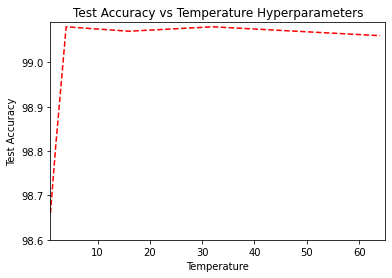

In [123]:
import matplotlib.pyplot as plt
scores_on_epoch_3 = [98.66, 98.81, 99.08, 99.07, 99.08, 99.06]
plt.plot(temperatures, scores_on_epoch_3, 'r--')
plt.axis([1, 65, 98.6, 99.09])
plt.title("Test Accuracy vs Temperature Hyperparameters")
plt.xlabel('Temperature')
plt.ylabel('Test Accuracy')
plt.show()

# 7) Train student from scratch

In [126]:
# Build fully connected student.
fc_model_no_distillation = tf.keras.Sequential()

# your code start from here for step 7
fc_model_no_distillation = tf.keras.Sequential()

fc_model_no_distillation.add(Flatten(input_shape=(28, 28, 1), name='s_noKD_Flatten'))
fc_model_no_distillation.add(Dense(784, activation='relu', name='s_noKD_Dense_1'))
fc_model_no_distillation.add(Dense(784, activation='relu', name='s_noKD_Dense_2'))
fc_model_no_distillation.add(Dense(10, name='s_noKD_logits'))



#@test {"output": "ignore"}

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = fc_model_no_distillation(images, training=True)
  
  #The model was built without softmax so the last layer or output will be the logits.
  cross_entropy_for_batch = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=student_subclass_logits/4)

  #Since this is a batch of images, we need to average the loss and return it.
  cross_entropy_loss = tf.reduce_mean(cross_entropy_for_batch)
  
  return cross_entropy_loss

NUM_EPOCHS = 12
train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

Epoch 1: Class_accuracy: 95.75%
Epoch 2: Class_accuracy: 96.97%
Epoch 3: Class_accuracy: 97.53%
Epoch 4: Class_accuracy: 97.89%
Epoch 5: Class_accuracy: 97.97%
Epoch 6: Class_accuracy: 97.92%
Epoch 7: Class_accuracy: 97.96%
Epoch 8: Class_accuracy: 98.04%
Epoch 9: Class_accuracy: 98.31%
Epoch 10: Class_accuracy: 98.20%
Epoch 11: Class_accuracy: 97.85%
Epoch 12: Class_accuracy: 98.13%


# 8) Comparing the Teacher and Student model (number of of parameters and FLOPs) 

In [130]:
# your code start from here for step 8
'''
#The following FLOPS code obtained from Keras-Flops:
/***************************************************************************************
*    Title: FLOPs calculator for neural network architecture written in tensorflow
*    Author: tokusumi
*    Date: August 17, 2020
*    Code version: N/A
*    Availability: https://github.com/tokusumi/keras-flops
*
***************************************************************************************/
'''
from keras_flops import get_flops
flops = get_flops(cnn_model, batch_size=BATCH_SIZE)
print("Teacher Model: ")
print(f"FLOPS: {flops / 10**9:.03} G")

flops = get_flops(fc_model, batch_size=BATCH_SIZE)
print("Student Model with KD: ")
print(f"FLOPS: {flops / 10**9:.03} G")

flops = get_flops(fc_model_no_distillation, batch_size=BATCH_SIZE)
print("Student Model without KD: ")
print(f"FLOPS: {flops / 10**9:.03} G")

Teacher Model: 
FLOPS: 5.64 G
Student Model with KD: 
FLOPS: 0.634 G
Student Model without KD: 
FLOPS: 0.634 G


# 9) XAI method to explain models

In [202]:
# RISE method obtained from Project A
import cv2
from time import time
import os
import numpy as np
import json

import tensorflow as tf
from tensorflow import keras
from scipy.ndimage.interpolation import zoom
from keras.preprocessing.image import load_img, img_to_array
import keras.backend as K
from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
#############################
  
def create_random_mask(h=7, w=7, H=224, W=224, p_1=0.5, resample=Image.BILINEAR):
    '''
    Generates one random mask utilized in RISE
    inputs:
        h, w: initial size of binary mask
        H, W: final size of the upsampled mask
        p_1: probability of actiating pixels in the down-sampled masks.
        interp: upsampling technique.
    returns:
        mask: a smooth mask with the values in range [0,1] with size of HxW.
    '''
    assert H>h, 'Masks should be resized to higher dimensions.'
    assert W>w, 'Masks should be resized to higher dimensions.'
    # create random binary hxw mask
    mask=np.random.choice([0, 1], size=(h, w), p=[1-p_1, p_1])

    # upsample mask to (h+H,w+W)
    mask = Image.fromarray(mask*255.)
    mask = mask.resize((H + h, W + w), resample=resample)
    mask = np.array(mask)

    # randomly crop mask to HxW
    w_crop = np.random.randint(0,w+1)
    h_crop = np.random.randint(0,h+1)
    mask = mask[h_crop:H + h_crop, w_crop:W + w_crop]

    # normalize between 0 and 1
    mask /= np.max(mask)
    return mask

def RISE(img, model, class_index, N_MASKS=8000, H=28, W=28, C=1):
    '''
	img: a 3-D input image
	model: a trained model
	class_index; The class of interest
	N_MASKS: The number of random masks to be generated
	H,W,C: The desired dimensions of the random masks
	'''
    X = np.zeros(shape=(N_MASKS, H, W, C), dtype=np.float32)
    masks = np.zeros((N_MASKS,H,W), dtype=np.float32)
    #for i in tqdm(range(N_MASKS)):
    for i in range(N_MASKS):
        m =create_random_mask(H=H, W=W)
        masks[i] = m
        x = img.copy()
        #print(x.shape)
        #print(m.shape)
        x[:, :, 0] *= m
        #x[:, :, 1] *= m
        #x[:, :, 2] *= m
        X[i] = x
    preds_masked = model.predict(X, verbose=0)
    sum_mask = np.zeros(masks[0].shape, dtype=np.float32)

    # np.einsum???
    for i, mask in enumerate(masks):
        m = mask * preds_masked[i, class_index]
        sum_mask += m

    sum_mask -= np.min(sum_mask)
    sum_mask /= np.max(sum_mask)
    return sum_mask

## RISE XAI Results

In [237]:
image_random = 0
label_random = 0
for images, labels in mnist_train:
    image_random = images
    label_random = labels
print("Label ", label_random[0].numpy().argmax())

RISE_teacher = RISE(image_random[0].numpy(), cnn_model, class_index=label_random[0].numpy().argmax(), N_MASKS=10000)
RISE_teacher -= RISE_teacher.min()
RISE_teacher /= RISE_teacher.max()+10e-30

RISE_student_KD = RISE(image_random[0].numpy(), fc_model, class_index=label_random[0].numpy().argmax(), N_MASKS=10000)
RISE_student_KD -= RISE_student_KD.min()
RISE_student_KD /= RISE_student_KD.max()+10e-30

RISE_student_noKD = RISE(image_random[0].numpy(), fc_model_no_distillation, class_index=label_random[0].numpy().argmax(), N_MASKS=10000)
RISE_student_noKD -= RISE_student_noKD.min()
RISE_student_noKD /= RISE_student_noKD.max()+10e-30


Label  4


(-0.5, 27.5, 27.5, -0.5)

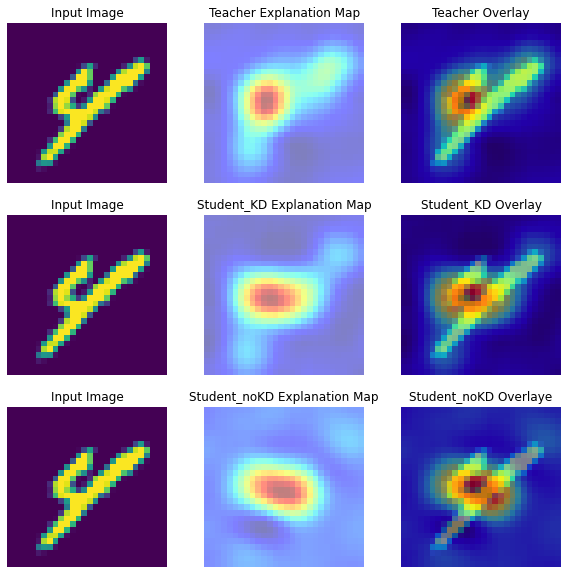

In [238]:
plt.figure(figsize=(10,10))

plt.subplot(3,3,1)
plt.title('Input Image')
plt.imshow(image_random[0].numpy())
plt.axis('off')

#################################
#Plot for Teacher
plt.subplot(3,3,2)
plt.title('Teacher Explanation Map')
plt.imshow(RISE_teacher, cmap='jet', alpha=0.5)
plt.axis('off')

plt.subplot(3,3,3)
plt.title('Teacher Overlay')
plt.imshow(image_random[0].numpy())
plt.imshow(RISE_teacher, cmap='jet', alpha=0.5)
plt.axis('off')

#################################
# Plot for Student with KD
plt.subplot(3,3,4)
plt.title('Input Image')
plt.imshow(image_random[0].numpy())
plt.axis('off')

plt.subplot(3,3,5)
plt.title('Student_KD Explanation Map')
plt.imshow(RISE_student_KD, cmap='jet', alpha=0.5)
plt.axis('off')

plt.subplot(3,3,6)
plt.title('Student_KD Overlay')
plt.imshow(image_random[0].numpy())
plt.imshow(RISE_student_KD, cmap='jet', alpha=0.5)
plt.axis('off')

#################################
#Plot for Student without KD

plt.subplot(3,3,7)
plt.title('Input Image')
plt.imshow(image_random[0].numpy())
plt.axis('off')

plt.subplot(3,3,8)
plt.title('Student_noKD Explanation Map')
plt.imshow(RISE_student_noKD, cmap='jet', alpha=0.5)
plt.axis('off')

plt.subplot(3,3,9)
plt.title('Student_noKD Overlaye')
plt.imshow(image_random[0].numpy())
plt.imshow(RISE_student_noKD, cmap='jet', alpha=0.5)
plt.axis('off')

# Implementing the state-of-the-art KD algorithm

## Double the Classes for Teacher and Student Model

In [ ]:
# Build CNN teacher.
cnn_model = tf.keras.Sequential()

# your code start from here for step 2
cnn_model.add(Conv2D(32, kernel_size=(3,3), strides=1, input_shape=(28, 28, 1), activation='relu', name='Conv1'))
cnn_model.add(MaxPooling2D(pool_size=(2,2), strides=1, name='MaxPool_1'))
cnn_model.add(Conv2D(64, kernel_size=(3,3), strides=1, activation='relu', name='Conv2'))
cnn_model.add(MaxPooling2D(pool_size=(2,2), strides=2, name='MaxPool_2'))
cnn_model.add(Flatten(name='Flatten'))
cnn_model.add(Dropout(rate=0.5, name="Dropout_1"))
cnn_model.add(Dense(128, activation='relu', name='Dense_1'))
cnn_model.add(Dropout(rate=0.5, name="Dropout_2"))
cnn_model.add(Dense(20, name='logits'))

In [ ]:
# Build fully connected student.
fc_model = tf.keras.Sequential()

fc_model.add(Flatten(input_shape=(28, 28, 1), name='s_Flatten'))
fc_model.add(Dense(784, activation='relu', name='s_Dense_1'))
fc_model.add(Dense(784, activation='relu', name='s_Dense_2'))
fc_model.add(Dense(20, name='s_logits'))

fc_model.summary()

## Teacher Loss Function

In [491]:
def compute_teacher_subclass_loss(images, labels):
  #Compute the subclass_logits and apply cross entropy on the logits of the model.
  subclass_logits = cnn_model(images, training=True)

  #Compute the Lxent part of the equation from paper
  probabilities = tf.nn.softmax(subclass_logits/4)
  lxent = tf.reduce_mean(tf.convert_to_tensor((-1/234)*np.dot(labels, np.log(sum(probabilities)))))

  #Compute the Laux part of the equation from paper
  laxu = tf.reduce_mean(tf.convert_to_tensor((1/234)*sum(np.log(np.exp(np.dot(labels.T, labels)/4))) - 1/4 - np.log(234)))
    
  teacher_subclass_loss_value = lxent + 0.1*laxu
  return teacher_subclass_loss_value

In [310]:
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 1. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):

  soft_targets = tf.nn.softmax(teacher_logits/temperature)
  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_subclass_loss(images, labels):
  student_subclass_logits = fc_model(images, training=True)
  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, 
                                              DISTILLATION_TEMPERATURE)
  
  #Compute the Lxent part of the equation from paper
  probabilities = tf.nn.softmax(student_subclass_logits/4)
  lxent = (-1/234)*labels*np.log(sum(probabilities))

  cross_entropy_loss_value = (1-ALPHA)*lxent + ALPHA*distillation_loss_value
  return cross_entropy_loss_value


In [492]:
import math
import numpy as np
#tf.config.run_functions_eagerly(False)
from tensorflow.python.ops.numpy_ops import np_config
#np_config.enable_numpy_behavior(False)

train_and_evaluate(cnn_model, compute_teacher_subclass_loss)

Epoch 1: tf.Tensor(-0.013926463, shape=(), dtype=float32)
[None, None, None, None, None, None, None, None]


ValueError: No gradients provided for any variable: (['Conv1/kernel:0', 'Conv1/bias:0', 'Conv2/kernel:0', 'Conv2/bias:0', 'Dense_1/kernel:0', 'Dense_1/bias:0', 'logits/kernel:0', 'logits/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'Conv1/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
array([[[[ 1.53874293e-01,  1.05659686e-01,  1.39574572e-01,
           8.66812542e-02,  3.22702527e-02,  6.94396645e-02,
          -1.25366345e-01, -2.14882523e-01,  1.91890031e-01,
          -5.30358478e-02, -9.06720236e-02,  1.17823277e-02,
          -2.09959552e-01,  1.19264692e-01, -3.15659761e-01,
           1.38473690e-01,  9.22448188e-02, -1.12721883e-01,
           8.07438195e-02, -3.34828764e-01,  1.18805006e-01,
          -4.57031161e-01,  1.71820477e-01, -1.57033019e-02,
           1.29630432e-01,  2.47576181e-02,  1.38550222e-01,
          -1.90388814e-01,  1.61036730e-01, -9.09420848e-02,
          -3.78053449e-02,  1.55630767e-01]],

        [[-2.15468332e-01, -1.34256959e-01,  1.91297978e-01,
           1.55652836e-01, -5.38259037e-02, -7.28403777e-02,
           1.44567974e-02,  1.73933238e-01, -1.75163805e-01,
          -1.85568511e-01,  1.44427970e-01,  6.66525587e-02,
          -8.18107799e-02,  1.14660718e-01, -1.74339134e-02,
           2.17634887e-02, -2.17895076e-01, -6.97380081e-02,
          -6.22202735e-03, -2.05897074e-02, -1.44317523e-02,
          -3.09231520e-01,  1.16782904e-01,  1.02824457e-01,
           9.62874964e-02, -4.94180107e-03, -1.51584893e-01,
          -8.01837668e-02,  1.45319000e-01, -2.37410381e-01,
          -1.47414804e-01,  6.49994090e-02]],

        [[-1.47502765e-01, -1.14346869e-01,  2.08187968e-01,
           9.30554233e-03, -2.16835588e-01, -1.02372058e-01,
          -2.59381592e-01, -8.66492316e-02, -2.46737763e-01,
          -1.36761934e-01, -1.13956593e-01,  1.71120867e-01,
          -5.48159927e-02,  3.44742984e-02, -9.18923020e-02,
           8.43688920e-02, -9.93112326e-02, -1.81540430e-01,
          -1.90382332e-01,  1.57913208e-01, -1.25740409e-01,
          -2.63326168e-01, -6.65782094e-02,  2.28891894e-01,
           4.63282950e-02, -2.54719108e-01,  8.96798372e-02,
           1.96295664e-01, -2.01241076e-01,  4.05047787e-03,
          -1.10695079e-01,  1.78483829e-01]]],


       [[[-2.28673995e-01,  2.40598619e-02, -9.37021673e-02,
           1.18494384e-01,  6.43561259e-02,  3.39757502e-02,
           9.91671756e-02, -1.73058897e-01,  2.10325867e-01,
           1.62233248e-01,  5.30039780e-02, -1.05545461e-01,
           1.13636270e-01, -2.15853482e-01, -1.53480604e-01,
          -2.26847213e-02, -1.34452179e-01,  3.04211657e-02,
          -1.40534893e-01, -7.82376453e-02, -6.44624755e-02,
          -4.17381898e-02,  1.97962388e-01,  1.27213541e-02,
           1.77003980e-01,  9.61371139e-02,  8.43375549e-02,
          -1.74644291e-01,  2.50123173e-01,  1.14688128e-01,
           1.11700529e-02, -1.29599974e-01]],

        [[ 4.85966913e-02,  1.79234911e-02, -1.13381259e-01,
           7.73677006e-02,  9.96299386e-02,  2.48476774e-01,
          -3.14748324e-02,  1.05807997e-01,  3.38726491e-02,
           1.79271743e-01,  1.29234582e-01, -2.67926633e-01,
           6.63134232e-02, -4.61040363e-02,  5.36168106e-02,
          -4.81403023e-02, -8.12323838e-02,  1.34187877e-01,
           2.05192909e-01,  2.96307921e-01,  3.27219442e-02,
          -9.11357626e-02, -4.60367501e-02, -9.05844048e-02,
           3.15824896e-02, -1.10406570e-01, -1.54306293e-01,
          -8.51484388e-03, -5.66837847e-01, -2.67302636e-02,
          -9.53711867e-02,  2.36668680e-02]],

        [[ 1.89372480e-01, -2.01532051e-01, -4.10311483e-02,
          -2.79807299e-01, -2.08636567e-01, -7.97240436e-02,
          -7.60847181e-02, -6.88384171e-04, -1.31573200e-01,
           4.33091559e-02, -1.86681464e-01, -2.39680111e-01,
           1.31253749e-01, -9.29142088e-02,  1.39055714e-01,
           4.57975976e-02,  1.68007344e-01, -3.92222703e-01,
           9.37853456e-02, -8.85074735e-02,  1.84745297e-01,
          -3.86893041e-02, -2.63651103e-01,  1.58280179e-01,
          -1.95056975e-01, -3.57491039e-02,  3.88033763e-02,
           8.19419883e-03, -9.63714346e-02,  1.49059430e-01,
          -5.82064800e-02,  2.25388780e-02]]],


       [[[ 1.94177598e-01,  1.65574417e-01, -1.42011598e-01,
          -4.63890322e-02,  1.55616462e-01, -2.81106919e-01,
           6.84576631e-02, -5.02811894e-02,  9.35463086e-02,
          -6.37633577e-02,  1.45709086e-02,  1.26115233e-01,
           1.48926601e-01,  6.91030994e-02, -3.49195570e-01,
           1.27339751e-01,  1.16518915e-01,  3.25630844e-01,
           8.10711682e-02,  1.13579435e-02,  1.07055813e-01,
          -6.78150132e-02,  6.00453205e-02, -3.23849857e-01,
          -9.67682898e-02, -3.49198747e-03, -2.80817691e-03,
          -1.47424176e-01, -4.25560862e-01, -4.12853509e-02,
           1.99079975e-01, -1.47886112e-01]],

        [[ 8.11184496e-02,  6.10221438e-02, -1.78032130e-01,
          -1.69940758e-02,  8.80210474e-02, -4.87426706e-02,
           6.49699271e-02,  5.35640493e-02, -7.26106837e-02,
           7.02195975e-05,  1.00531831e-01,  1.73813403e-01,
           3.48099172e-02, -3.36875133e-02,  3.54635678e-02,
          -2.36262549e-02,  4.76318263e-02, -1.48588687e-01,
          -1.73763424e-01,  1.55889496e-01,  3.64348805e-03,
           1.64567664e-01, -1.57806188e-01, -1.23033971e-01,
          -1.29742384e-01,  1.86537921e-01, -2.72230059e-02,
           4.52059098e-02, -2.47388616e-01,  1.91076711e-01,
           1.53340027e-01, -2.43900120e-01]],

        [[-5.32376803e-02, -6.64010830e-03, -7.85584971e-02,
          -1.22057371e-01, -2.57945936e-02,  1.46586910e-01,
           1.03820696e-01,  1.44864127e-01,  9.60805938e-02,
          -8.68355781e-02,  1.07261047e-01, -1.65343527e-02,
           6.12132102e-02,  1.78418621e-01,  1.01325966e-01,
          -2.49152228e-01,  1.07937403e-01, -2.97760189e-01,
          -9.62685421e-03, -2.65291184e-01, -3.62345316e-02,
           2.88537145e-01, -3.12911645e-02,  1.73424475e-03,
          -1.60698324e-01,  1.22011051e-01,  1.27301738e-01,
           1.69327497e-01,  2.27845013e-01, -1.47554083e-02,
          -7.44678825e-03, -1.05270065e-01]]]], dtype=float32)>), (None, <tf.Variable 'Conv1/bias:0' shape=(32,) dtype=float32, numpy=
array([-5.40974922e-02, -3.01699676e-02,  1.20450165e-02, -3.17571089e-02,
       -1.01627745e-02, -4.38966453e-02, -2.31531728e-03, -4.94922772e-02,
       -7.24829510e-02, -1.83114223e-03, -1.17116138e-01, -6.95713470e-03,
       -1.22585960e-01, -1.16632588e-01, -9.62921605e-03, -6.54286072e-02,
       -5.15887588e-02,  3.68478475e-04, -6.42389283e-02, -2.97661740e-02,
       -1.38085604e-01, -4.23331279e-03, -1.24527737e-02, -3.98811884e-02,
       -1.92414001e-02, -6.27311990e-02, -8.71006921e-02, -7.75041245e-03,
        1.83589924e-02, -8.88474211e-02, -7.88073521e-05, -9.02850926e-03],
      dtype=float32)>), (None, <tf.Variable 'Conv2/kernel:0' shape=(3, 3, 32, 64) dtype=float32, numpy=
array([[[[-7.06751272e-02,  6.38554022e-02, -4.34342697e-02, ...,
          -1.08299091e-01,  4.71490212e-02, -1.13523759e-01],
         [ 4.74599972e-02,  1.72045365e-01, -2.03495041e-01, ...,
          -1.52611420e-01,  1.65105194e-01,  6.83132038e-02],
         [-1.32569164e-01, -1.22562172e-02, -1.20180331e-01, ...,
          -2.90490296e-02,  1.10625111e-01,  1.32522956e-01],
         ...,
         [-5.64219505e-02, -9.87022445e-02,  1.72424577e-02, ...,
          -1.87309608e-01,  4.22493257e-02, -3.15017283e-01],
         [-2.15262827e-03,  1.09320477e-01, -1.79524168e-01, ...,
          -2.20107198e-01,  5.09715034e-03, -4.85871248e-02],
         [-1.82092309e-01,  2.81174723e-02, -1.71875600e-02, ...,
           8.14350322e-02,  1.33141458e-01,  9.78743359e-02]],

        [[-1.75141506e-02,  8.33757594e-02, -1.11593910e-01, ...,
          -1.61633894e-01,  1.86147150e-02,  2.62071844e-02],
         [ 1.33478284e-01,  4.18298095e-02, -1.11692451e-01, ...,
           1.00016765e-01,  1.60641447e-01, -2.34688651e-02],
         [ 2.32988335e-02,  1.86944883e-02, -1.59390420e-01, ...,
          -1.74087480e-01, -4.33851555e-02,  1.02957949e-01],
         ...,
         [-2.28819321e-04, -1.10972635e-02, -1.17983088e-01, ...,
          -2.34361086e-02,  2.03720361e-01, -1.24408022e-01],
         [ 1.35965928e-01,  1.19273312e-01, -2.11198837e-01, ...,
           1.31953239e-01,  2.93068867e-02, -7.81508312e-02],
         [-9.89983510e-03, -4.38545905e-02,  1.10213121e-03, ...,
           3.49913258e-03,  5.60973845e-02,  1.04379699e-01]],

        [[-3.97749469e-02,  7.22349137e-02, -1.12588920e-01, ...,
           3.42432712e-03, -1.18288621e-01,  4.39734347e-02],
         [ 1.07544087e-01, -8.84288400e-02, -3.13191116e-02, ...,
           1.05551116e-01,  1.02951527e-01,  1.89988971e-01],
         [-1.67126749e-02,  4.78151329e-02, -9.89035442e-02, ...,
          -5.77616654e-02,  4.75584622e-03,  3.84487361e-02],
         ...,
         [-7.10825473e-02, -1.27914533e-01, -2.39445865e-01, ...,
           3.33997346e-02,  1.25306278e-01, -2.34921519e-02],
         [ 5.71771860e-02,  6.79017529e-02, -8.80328491e-02, ...,
           1.19209819e-01,  7.52794323e-03,  1.19891167e-01],
         [ 7.76638314e-02,  1.42368469e-02, -2.03502238e-01, ...,
          -9.79504287e-02,  8.68081395e-03,  1.49386033e-01]]],


       [[[ 9.03542677e-05, -2.53820848e-02, -1.22315124e-01, ...,
           5.79788461e-02, -2.56112307e-01, -3.84112746e-01],
         [-8.60233083e-02, -1.13841775e-03, -2.31254667e-01, ...,
          -6.34325296e-02, -1.29304528e-01, -9.67011005e-02],
         [-5.23893088e-02,  1.84493482e-01, -1.34000927e-01, ...,
          -7.87423998e-02,  2.47934107e-02, -1.85714699e-02],
         ...,
         [-1.05731606e-01, -4.84105162e-02, -4.35025990e-02, ...,
          -4.18606251e-02, -1.84855238e-01, -2.26140857e-01],
         [-3.01099662e-02, -7.88331591e-03, -3.23530465e-01, ...,
          -3.13551843e-01, -1.17161870e-01, -1.41084731e-01],
         [-1.10011153e-01,  1.92778781e-01,  3.82479019e-02, ...,
           3.98701057e-02,  2.96235867e-02, -5.26741035e-02]],

        [[-6.45798519e-02,  6.43131137e-02, -2.66788602e-01, ...,
          -3.14580053e-02,  4.92583849e-02, -6.69070482e-02],
         [ 4.86871563e-02, -4.75846194e-02, -1.63013004e-02, ...,
           1.23691976e-01,  2.04485711e-02,  1.21183312e-02],
         [-1.79498360e-01,  1.12696635e-02, -3.04146931e-02, ...,
           1.88572367e-03,  1.00510150e-01, -4.14009392e-03],
         ...,
         [-1.10419869e-01,  1.08953379e-02, -3.07001788e-02, ...,
           4.39073076e-04, -6.85026795e-02, -1.31791294e-01],
         [ 1.03416048e-01,  1.83716282e-01, -1.00388685e-02, ...,
           2.66331490e-02, -9.97274145e-02,  8.83074477e-02],
         [-7.42547587e-02,  8.86264369e-02, -1.44181848e-01, ...,
           7.98687413e-02,  4.01183628e-02,  1.30672947e-01]],

        [[-1.43199548e-01,  3.01456675e-02, -2.70928413e-01, ...,
           4.59760660e-03,  1.34801194e-01,  1.53433122e-02],
         [-3.02440440e-03, -1.11361049e-01, -6.54159188e-02, ...,
          -3.27657200e-02, -9.20133665e-02, -1.03765368e-01],
         [-1.03132538e-01,  9.31294411e-02, -1.11253016e-01, ...,
          -2.11863026e-01,  1.13962339e-02,  5.02744876e-02],
         ...,
         [-2.03036755e-01, -1.16251275e-01, -1.72218442e-01, ...,
           8.61580484e-03, -9.44478437e-02, -6.15552254e-03],
         [ 1.15924142e-02, -2.55805366e-02, -1.01023220e-01, ...,
           9.29637775e-02, -2.59455264e-01,  1.14217676e-01],
         [-1.81028500e-01,  8.56245086e-02, -6.51628748e-02, ...,
          -1.17998295e-01, -6.20901808e-02,  3.15607265e-02]]],


       [[[-7.89003521e-02, -1.66660860e-01, -2.14330092e-01, ...,
          -6.78677410e-02, -1.49013743e-01, -1.54559657e-01],
         [-7.24575855e-03, -5.52487597e-02, -2.14865878e-01, ...,
          -8.14148486e-02, -1.51482344e-01, -6.25097100e-03],
         [-2.11180910e-01,  5.19962469e-03, -6.75520375e-02, ...,
          -1.73839301e-01,  7.74722099e-02,  1.18214479e-02],
         ...,
         [ 7.83949941e-02, -2.16703638e-01, -8.80329534e-02, ...,
           8.98185223e-02, -1.61159888e-01, -1.22935295e-01],
         [-1.97613224e-01,  1.28087893e-01, -5.05996168e-01, ...,
           3.16578546e-03,  1.92091227e-01,  1.05650434e-02],
         [-1.95593953e-01,  1.01811439e-02, -4.61626165e-02, ...,
          -1.24166586e-01,  4.44452837e-02,  5.32586202e-02]],

        [[-1.37098730e-01, -1.27424449e-02, -2.20048547e-01, ...,
          -1.06262989e-01,  2.98615750e-02, -2.15893269e-01],
         [ 3.31999585e-02, -1.49045959e-01, -1.08807206e-01, ...,
           4.44259355e-03, -3.29115748e-01, -9.28536877e-02],
         [-8.70588124e-02,  6.73647299e-02,  1.95419174e-02, ...,
          -1.06931470e-01, -4.96104360e-03,  5.06825857e-02],
         ...,
         [ 2.59983744e-02,  7.32754469e-02, -1.65744513e-01, ...,
          -6.33415207e-02, -9.29861292e-02, -4.29549396e-01],
         [-1.84374362e-01, -1.49990082e-01, -6.73570633e-02, ...,
           1.14118204e-01, -6.03408851e-02, -3.17292586e-02],
         [-1.54995665e-01, -7.34427646e-02,  2.22108606e-02, ...,
          -1.61338061e-01,  3.53265330e-02,  9.87457782e-02]],

        [[-3.65282744e-01, -4.66784947e-02, -4.08213079e-01, ...,
           3.88245359e-02,  2.13603750e-01, -2.63985306e-01],
         [ 2.93972529e-02, -2.01948229e-02, -3.73515822e-02, ...,
          -3.63610126e-02, -2.07277700e-01, -1.88164160e-01],
         [-1.05165824e-01,  2.63570249e-02, -8.74935314e-02, ...,
          -1.17948376e-01, -6.13945425e-02,  1.61197305e-01],
         ...,
         [-3.17302257e-01,  1.99936792e-01, -2.10618675e-01, ...,
          -3.48527320e-02,  8.11185315e-02, -1.92744136e-01],
         [-9.38731879e-02, -1.14844799e-01,  1.49920788e-02, ...,
           6.18275031e-02, -2.47065172e-01, -2.19193578e-01],
         [-1.44521073e-01, -5.47612980e-02,  2.08596811e-02, ...,
          -1.12910062e-01, -1.17955297e-01,  1.72796324e-01]]]],
      dtype=float32)>), (None, <tf.Variable 'Conv2/bias:0' shape=(64,) dtype=float32, numpy=
array([-0.00791462, -0.06217992,  0.0658102 ,  0.00793871, -0.01941552,
       -0.09633823, -0.02252694, -0.00944544, -0.04145909, -0.04787337,
       -0.05801359, -0.01799274, -0.0652981 , -0.01881283, -0.17694093,
       -0.04300321, -0.00033457, -0.08044074,  0.01554791, -0.0286928 ,
       -0.05832186, -0.0353377 ,  0.00916415, -0.02565315, -0.04254837,
       -0.02054415, -0.03599982, -0.02526994,  0.03475434, -0.03663106,
       -0.04557932, -0.06120583, -0.0511413 ,  0.00100185, -0.05784438,
       -0.03451907, -0.06087396,  0.05624307, -0.07150691, -0.00072004,
       -0.06195438, -0.06019086, -0.08252248, -0.06314345, -0.00580262,
       -0.02692057, -0.05626646, -0.00635555, -0.01334836, -0.01032115,
       -0.06562261, -0.08435735,  0.00094985, -0.04201776, -0.00601534,
       -0.1066538 ,  0.02038504, -0.01933324, -0.05646297, -0.02163039,
        0.00309953, -0.09487894, -0.02294104,  0.01547448], dtype=float32)>), (None, <tf.Variable 'Dense_1/kernel:0' shape=(7744, 128) dtype=float32, numpy=
array([[ 1.94961019e-02,  4.11559306e-02,  4.08033989e-02, ...,
         1.02558704e-02,  2.66470090e-02,  1.32135849e-03],
       [ 3.36451456e-03,  2.73952223e-02,  2.41168868e-02, ...,
         8.34273451e-05,  2.03662924e-02, -7.27240089e-03],
       [ 1.03636958e-01,  8.39702561e-02,  1.31430581e-01, ...,
        -7.75510911e-03,  4.85966913e-02,  1.20158843e-03],
       ...,
       [ 8.52296278e-02,  4.60849442e-02, -1.00852326e-01, ...,
         1.13204801e-02, -2.51292791e-02,  1.82403654e-01],
       [-3.10605881e-03, -4.38268781e-02,  1.01571921e-02, ...,
        -7.42203966e-02, -2.48831250e-02, -1.00719705e-01],
       [ 1.12667661e-02,  9.79161710e-02, -6.26313314e-02, ...,
        -7.73577243e-02, -1.38013095e-01, -3.94768342e-02]], dtype=float32)>), (None, <tf.Variable 'Dense_1/bias:0' shape=(128,) dtype=float32, numpy=
array([-0.07460183, -0.0722665 , -0.16627815, -0.09360414, -0.19532396,
       -0.10184207, -0.15866022, -0.12136307, -0.14514875, -0.09764109,
       -0.09301504, -0.11300853, -0.12153544, -0.17375743, -0.07121713,
       -0.1272529 , -0.1782321 , -0.07994468, -0.00600435, -0.14829205,
       -0.09593514, -0.09845599, -0.14278273, -0.08310878, -0.13095318,
       -0.12623125, -0.07122806, -0.07266477, -0.08850375, -0.10569171,
       -0.14863668, -0.12321479, -0.15235293, -0.15782553, -0.12788892,
       -0.13270661, -0.18856694, -0.09720634, -0.10769232, -0.12539612,
       -0.06587407, -0.06157776, -0.12696178, -0.1307908 , -0.12519158,
       -0.13285436, -0.13921092, -0.01873877, -0.115376  , -0.04769461,
       -0.04863321, -0.05652851, -0.06207287, -0.0890943 , -0.14639026,
       -0.11079238, -0.16457781, -0.08969796, -0.12724884, -0.13704853,
       -0.11845022, -0.051227  , -0.09911217, -0.04912968,  0.00905888,
       -0.0711316 , -0.1375486 , -0.1420437 , -0.19762757, -0.10381221,
       -0.15128176, -0.08992769, -0.17216462, -0.08003131, -0.18662234,
       -0.0069993 , -0.17154601, -0.05133016, -0.13139595, -0.09198188,
       -0.07052618, -0.1232718 , -0.12697002, -0.1405501 , -0.12066104,
       -0.10740654, -0.16347878, -0.19843152, -0.01569769, -0.12214515,
       -0.15807049, -0.15718535, -0.03460643, -0.16703874, -0.06983205,
       -0.03913417, -0.00835076, -0.14756612, -0.1015217 , -0.17747223,
       -0.1473687 , -0.14669956, -0.14392337, -0.1218199 , -0.19087921,
        0.0244024 , -0.05088311, -0.10094206, -0.08526716, -0.15085094,
       -0.06828178, -0.14172097, -0.09807608, -0.11390316, -0.05855598,
       -0.07919908, -0.12740856, -0.1287596 , -0.12964995, -0.14540157,
       -0.13746268, -0.0679922 , -0.10922075, -0.07578566, -0.12327047,
       -0.11703685, -0.07379308, -0.17479236], dtype=float32)>), (None, <tf.Variable 'logits/kernel:0' shape=(128, 10) dtype=float32, numpy=
array([[-0.45914268,  0.03581625, -0.25935164, ...,  0.07640684,
        -0.36554158,  0.07651527],
       [-0.09447367,  0.11257371,  0.19856746, ...,  0.15547986,
        -0.27880108, -0.14542255],
       [ 0.05572826, -0.34500444,  0.1384597 , ...,  0.1127457 ,
         0.13257945,  0.06390943],
       ...,
       [-0.2714989 ,  0.04420299, -0.34766012, ..., -0.42662242,
         0.13387686, -0.2267926 ],
       [ 0.29144886,  0.2636244 , -0.08671752, ..., -0.33760297,
         0.15838064, -0.06133465],
       [-0.41916025, -0.3782469 , -0.30613607, ...,  0.15506831,
         0.2105298 ,  0.18744801]], dtype=float32)>), (None, <tf.Variable 'logits/bias:0' shape=(10,) dtype=float32, numpy=
array([ 0.08873459,  0.10833282,  0.08429127, -0.04555475, -0.07497814,
       -0.11680175, -0.20929353, -0.09129977,  0.07342541,  0.08074086],
      dtype=float32)>)).